https://www.youtube.com/watch?v=NoRXON3YJ_A

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['H5PY_DEFAULT_READONLY'] = '1'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_hub as hub
import tensorflowjs as tfjs    

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.__version__

'2.1.0'

In [3]:
# for plotting images (optional)
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20, 20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

In [4]:
# getting data
train_dir = os.path.join('images', 'train')
validation_dir = os.path.join('images', 'validation')
train_cats = os.path.join(train_dir, 'cats')
train_dogs = os.path.join(train_dir, 'dogs')
validation_cats = os.path.join(validation_dir, 'cats')
validation_dogs = os.path.join(validation_dir, 'dogs')
num_cats_tr = len(os.listdir(train_cats))
num_dogs_tr = len(os.listdir(train_dogs))
num_cats_val = len(os.listdir(validation_cats))
num_dogs_val = len(os.listdir(validation_dogs))
total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val
print(total_val)

1000


In [5]:
#generators
BATCH_SIZE = 5
IMG_SHAPE = 224 # match image dimension to mobile net input

train_image_generator = ImageDataGenerator(rescale=1./255)
validation_image_generator = ImageDataGenerator(rescale=1./255)

train_data_gen = train_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_SHAPE, IMG_SHAPE),
                                                           class_mode='binary')

val_data_gen = train_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                           directory=validation_dir,
                                                           shuffle=False,
                                                           target_size=(IMG_SHAPE, IMG_SHAPE),
                                                           class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [6]:
# model
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4" # getting MobileNet
mobile_net = hub.KerasLayer(URL, input_shape=(IMG_SHAPE, IMG_SHAPE, 3))

mobile_net.trainable = False

model = tf.keras.models.Sequential([
    mobile_net,
    tf.keras.layers.Dense(2, activation='softmax') #[0, 1] or [1, 0]
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

EPOCHS = 5

history = model.fit(
    train_data_gen,
    steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
    epochs=EPOCHS,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(total_val / float(BATCH_SIZE)))
)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________
Train for 400 steps, validate for 200 steps
Epoch 1/5
400/400 [==============================] - 37s 93ms/step - loss: 0.1108 - accuracy: 0.9535 - val_loss: 0.0487 - val_accuracy: 0.9820
Epoch 2/5
400/400 [==============================] - 34s 86ms/step - loss: 0.0412 - accuracy: 0.9850 - val_loss: 0.0440 - val_accuracy: 0.9860
Epoch 3/5
400/400 [==============================] - 34s 86ms/step - loss: 0.0220 - accuracy: 0.9935 - val_loss: 0.0457 - val_accuracy: 0.9850
Epoch 4/5
400/400 [============

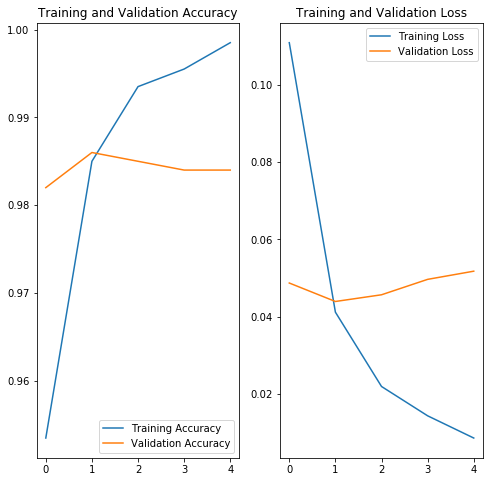

In [7]:
# analysis
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [8]:
tfjs.converters.save_keras_model(model, "js")